In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math
from torch.utils.data import DataLoader

In [3]:
train_dataset = Dataloader.time_series_paper(96,4500)
validation_dataset = Dataloader.time_series_paper(96,500)
test_dataset = Dataloader.time_series_paper(96,1000)

x: 4500*120 fx: 4500*120
x: 500*120 fx: 500*120
x: 1000*120 fx: 1000*120


In [4]:
criterion = torch.nn.MSELoss()

In [5]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

# LSTM ATTEMPT

In [6]:
class LSTM_Time_Series(torch.nn.Module):
    def __init__(self,input_size=2,embedding_size=256,kernel_width=9,hidden_size=512,t0=96):
        super(LSTM_Time_Series,self).__init__()
        
        self.input_embedding = causal_convolution_layer.context_embedding(input_size,embedding_size,kernel_width)    
        
        self.lstm = torch.nn.LSTM(embedding_size,hidden_size,batch_first=True)
        
        self.fc1 = torch.nn.Linear(hidden_size,1)

        self.t0 = t0
        
    def forward(self,x,y):
        """
        x: the time covariate
        y: the observed target
        """
        # concatenate observed points and time covariate
        # (B,input size + covariate size,sequence length)
        z_obs = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (B,embedding size,sequence length)
        z_obs_embedding = self.input_embedding(z_obs)
        
        # permute axes (B,sequence length, embedding size)
        z_obs_embedding = self.input_embedding(z_obs).permute(0,2,1)
                
        # all hidden states from lstm
        # (B,sequence length,num_directions * hidden size)
        lstm_out,_ = self.lstm(z_obs_embedding)
        
        # input to nn.Linear: (N,*,Hin)
        # output (N,*,Hout)
        return self.fc1(lstm_out[:,(self.t0-1):,:])

In [7]:
criterion_LSTM = torch.nn.MSELoss()

In [8]:
LSTM = LSTM_Time_Series(t0=96).cuda()

In [9]:
lr = .0005 # learning rate
optimizer = torch.optim.Adam(LSTM.parameters(), lr=lr)
epochs = 100

In [10]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [11]:
def train_epoch(LSTM,train_dl):
    LSTM.train()
    train_loss = 0
    n = 0
    for step,(x_obs,x_future,y_obs,y_future,_) in enumerate(train_dl):
        x = torch.cat((x_obs,x_future),1).cuda()
        y = torch.cat((y_obs,y_future),1).cuda()
        h0 = torch.ones((x.shape[0],1,256),dtype=torch.float)
        c0 = torch.ones((x.shape[0],1,256),dtype=torch.float)
        
        optimizer.zero_grad()
        output = LSTM(x,y)
        loss = criterion(output.squeeze()[:,:-1],y_future.cuda()[:,1:])        
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [12]:
def eval_epoch(LSTM,validation_dl):
    LSTM.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x_obs,x_future,y_obs,y_future,_) in enumerate(validation_dl):
            x = torch.cat((x_obs,x_future),1).cuda()
            y = torch.cat((y_obs,y_future),1).cuda()
            h0 = torch.ones((x.shape[0],1,256),dtype=torch.float)
            c0 = torch.ones((x.shape[0],1,256),dtype=torch.float)

            output = LSTM(x,y)
            loss = criterion(output.squeeze()[:,:-1],y_future.cuda()[:,1:])        
        
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [13]:
def test_epoch(LSTM,test_dl):
    with torch.no_grad():
        predictions = []
        observations = []

        LSTM.eval()
        for step,(x_obs,x_future,y_obs,y_future,_) in enumerate(test_dl):
            x = torch.cat((x_obs,x_future),1).cuda()
            y = torch.cat((y_obs,y_future),1).cuda()
            h0 = torch.ones((x.shape[0],1,256),dtype=torch.float)
            c0 = torch.ones((x.shape[0],1,256),dtype=torch.float)

            output = LSTM(x,y)

            for p,o in zip(output.squeeze()[:,:-1].cpu().numpy().tolist(),y_future.cuda()[:,1:].cpu().numpy().tolist()):

                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [14]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_train = train_epoch(LSTM,train_dl)
    train_loss.append(l_train)
    
    l_eval = eval_epoch(LSTM,validation_dl)
    eval_loss.append(l_eval)
            
    Rp = test_epoch(LSTM,test_dl)
    
    if Rp_best > Rp:
        Rp_best = Rp

    with torch.no_grad():
        print("Epoch {}: Train loss={} \t Eval loss = {} \t Rp={}".format(e,np.mean(train_loss),np.mean(eval_loss),Rp))
        
        train_epoch_loss.append(np.mean(train_loss))
        eval_epoch_loss.append(np.mean(eval_loss))

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Train loss=3060.002558268229 	 Eval loss = 1732.1191552734374 	 Rp=0.46880998939629726
Epoch 1: Train loss=1274.10401953125 	 Eval loss = 1006.2846279296875 	 Rp=0.36058791506903065
Epoch 2: Train loss=946.5258338216146 	 Eval loss = 913.7602143554687 	 Rp=0.3462634615651801
Epoch 3: Train loss=913.1190835503472 	 Eval loss = 907.9845659179688 	 Rp=0.34429527960406553
Epoch 4: Train loss=903.599722764757 	 Eval loss = 854.2870092773437 	 Rp=0.3325671753129886
Epoch 5: Train loss=517.2180242648654 	 Eval loss = 206.0650263671875 	 Rp=0.11660603610026944
Epoch 6: Train loss=131.78727689615886 	 Eval loss = 82.51239721679687 	 Rp=0.07038835868660497
Epoch 7: Train loss=60.10636205715603 	 Eval loss = 41.95346575927734 	 Rp=0.05234998754915497
Epoch 8: Train loss=31.937736423068575 	 Eval loss = 23.88346838378906 	 Rp=0.039291325735154536
Epoch 9: Train loss=19.159629420810276 	 Eval loss = 15.187950378417968 	 Rp=0.0324962524639332
Epoch 10: Train loss=12.75779572974311 	 Eval lo

Epoch 85: Train loss=1.6489237012863158 	 Eval loss = 1.8368999376296997 	 Rp=0.014895166308351276
Epoch 86: Train loss=1.6574763278961182 	 Eval loss = 2.064714319229126 	 Rp=0.01587596071569922
Epoch 87: Train loss=1.5657483386993407 	 Eval loss = 1.5914024276733398 	 Rp=0.013816785014890571
Epoch 88: Train loss=1.594959451675415 	 Eval loss = 1.5908545217514038 	 Rp=0.013774653966302374
Epoch 89: Train loss=1.5687389249801635 	 Eval loss = 1.6759311456680297 	 Rp=0.014281750768693723
Epoch 90: Train loss=1.5147794914245605 	 Eval loss = 1.4691371698379516 	 Rp=0.01321345925060795
Epoch 91: Train loss=1.5073800680372451 	 Eval loss = 1.5144158296585084 	 Rp=0.01343597671939165
Epoch 92: Train loss=1.6491620025634766 	 Eval loss = 1.5335977334976196 	 Rp=0.013611457970846112
Epoch 93: Train loss=1.6020217315885756 	 Eval loss = 1.527285626411438 	 Rp=0.013467411062860514
Epoch 94: Train loss=1.5716593514548407 	 Eval loss = 1.4962359924316406 	 Rp=0.013411655524217674
Epoch 95: Train 

In [15]:
print("Best Rp={}".format(Rp_best))

Best Rp=0.013067935711401397


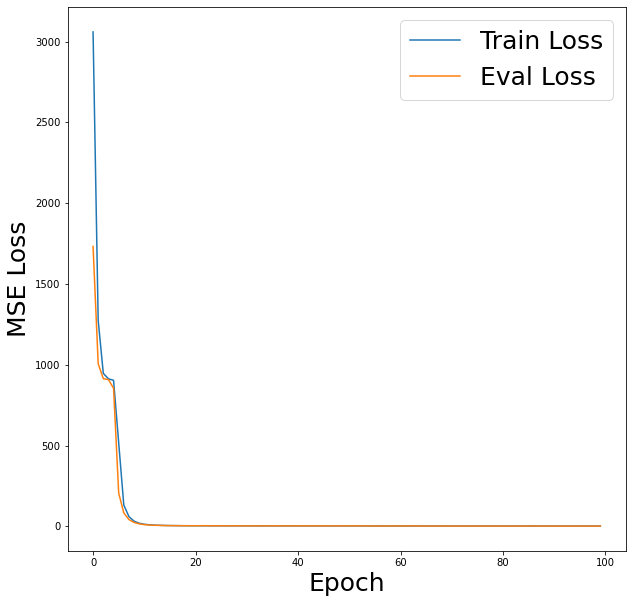

In [16]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

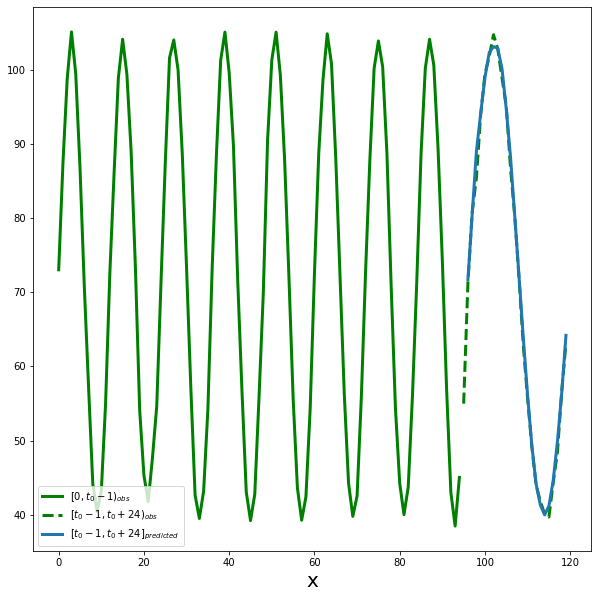

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


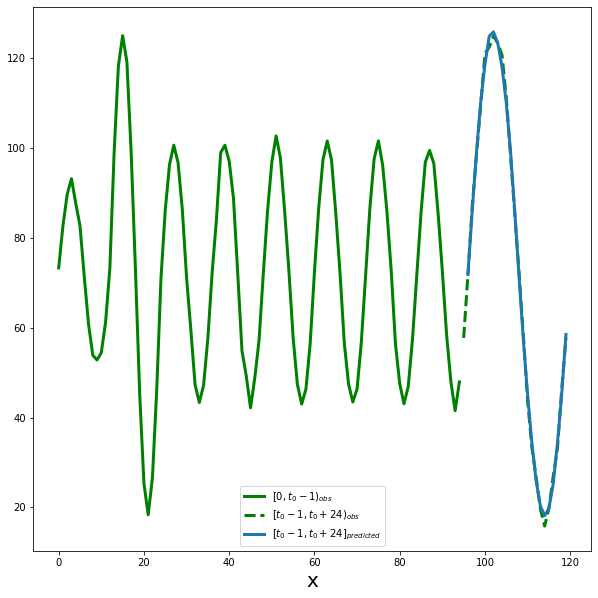

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


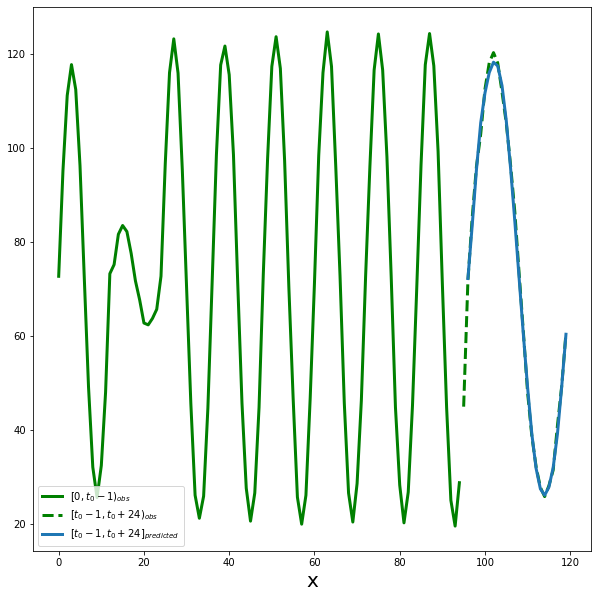

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


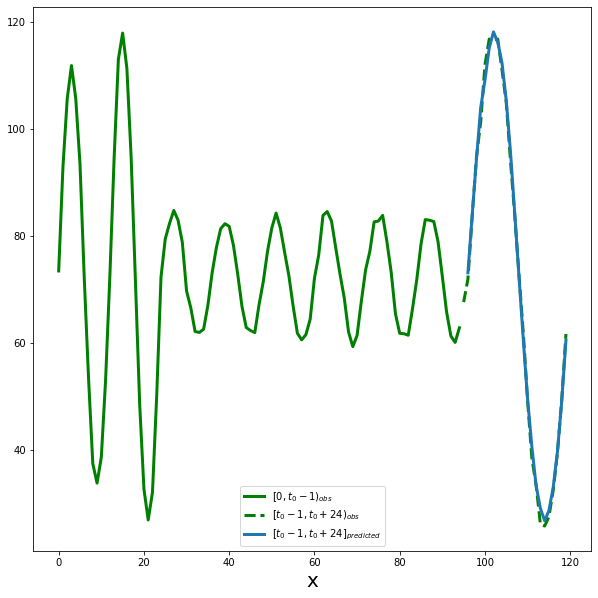

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


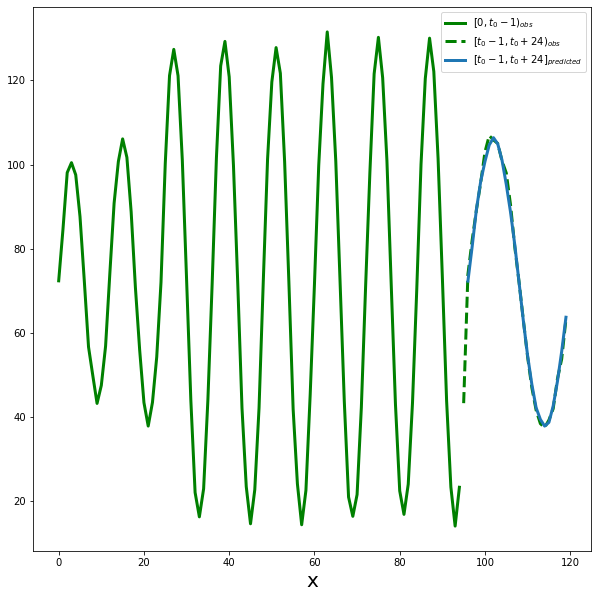

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


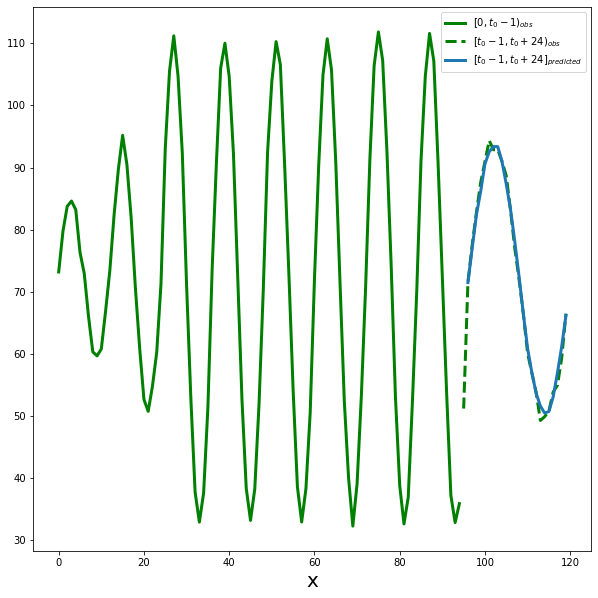

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [17]:
n_plots = 5
with torch.no_grad():
    LSTM.eval()
    for step,(x_obs,x_future,y_obs,y_future,_) in enumerate(validation_dl):
        x = torch.cat((x_obs,x_future),1).cuda()
        y = torch.cat((y_obs,y_future),1).cuda()
        h0 = torch.ones((x.shape[0],1,256),dtype=torch.float)
        c0 = torch.ones((x.shape[0],1,256),dtype=torch.float)

        output = LSTM(x,y)


        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            plt.plot(x_obs[0].cpu().detach().squeeze().numpy(),y_obs[0].cpu().detach().squeeze().numpy(),'g-',linewidth=3)
            plt.plot(x_future[0].cpu().detach().squeeze().numpy(),y_future[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)

            plt.plot(x_future[0].cpu().detach().squeeze().numpy()[1:],output[0].cpu().detach().squeeze().numpy()[:-1],linewidth=3)
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0-1)_{obs}$","$[t_0-1,t_0+24)_{obs}$","$[t_0-1,t_0+24]_{predicted}$"])
            plt.show()